***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 03/01}}$<br>

### Updates:
- Train Test Split Function(randomized)
- Randomized Grid Search Function
- Capability for Cross Validation

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [3]:
%%time
Sim_folder_names = []
i = 0
for file in glob.glob("Sim_*"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 55
['Sim_A_0_B_77', 'Sim_A_44_B_55', 'Sim_A_55_B_22', 'Sim_A_22_B_77', 'Sim_A_88_B_11', 'Sim_A_22_B_22', 'Sim_A_33_B_0', 'Sim_A_33_B_55', 'Sim_A_0_B_22', 'Sim_A_22_B_0', 'Sim_A_66_B_11', 'Sim_A_11_B_44', 'Sim_A_11_B_88', 'Sim_A_11_B_11', 'Sim_A_0_B_100', 'Sim_A_77_B_11', 'Sim_A_11_B_33', 'Sim_A_11_B_66', 'Sim_A_66_B_33', 'Sim_A_44_B_0', 'Sim_A_44_B_22', 'Sim_A_55_B_0', 'Sim_A_100_B_0', 'Sim_A_22_B_55', 'Sim_A_0_B_55', 'Sim_A_33_B_22', 'Sim_A_33_B_66', 'Sim_A_0_B_11', 'Sim_A_44_B_33', 'Sim_A_55_B_44', 'Sim_A_66_B_0', 'Sim_A_0_B_0', 'Sim_A_22_B_11', 'Sim_A_55_B_11', 'Sim_A_22_B_44', 'Sim_A_33_B_33', 'Sim_A_0_B_88', 'Sim_A_0_B_44', 'Sim_A_11_B_22', 'Sim_A_66_B_22', 'Sim_A_11_B_77', 'Sim_A_77_B_0', 'Sim_A_88_B_0', 'Sim_A_11_B_0', 'Sim_A_11_B_55', 'Sim_A_77_B_22', 'Sim_A_44_B_44', 'Sim_A_0_B_66', 'Sim_A_33_B_11', 'Sim_A_22_B_66', 'Sim_A_55_B_33', 'Sim_A_22_B_33', 'Sim_A_44_B_11', 'Sim_A_0_B_33', 'Sim_A_33_B_44']
CPU times: user 701 µs, sys: 682 µs, total: 1.38 ms
Wall

In [4]:
set_init_coverages = np.empty([len(Sim_folder_names),4])
#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter

In [5]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [6]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
Exp_init_coverages = np.empty([len(Sim_folder_names),4])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    Exp_init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

<a id="1.1"></a> 
## 1.1 Checking all simulations were completed as expected
<a href="#top">Back to top</a>

In [7]:
if np.shape(set_init_coverages) != np.shape(Exp_init_coverages):
    raise Exception('Not all simulations have been completed successfully')
    
for i in np.arange(np.shape(set_init_coverages)[0]):
    for j in np.arange(np.shape(set_init_coverages)[1]):
        norm_val = set_init_coverages[i,j]
        exp_val = round(Exp_init_coverages[i,j])
        if not( norm_val + 1 > exp_val) and not(norm_val - 1 < exp_val): #i.e if not within range
            raise Exception('Initial coverages used in the simulation are not the same as it was set')
            
        if (i==(np.shape(set_init_coverages)[0] - 1) and j==(np.shape(set_init_coverages)[1] - 1)):
            print('SIMULATIONS MATCH AS EXPECTED')

SIMULATIONS MATCH AS EXPECTED


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [8]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

In [9]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n = len(Sim_folder_names)
Covg = np.zeros((n,500,4)) #CO*, O*, O2*, *
Rates = np.zeros((n,500,3)) #CO, O2, CO2
KMC_time_Array = np.zeros((n,500))
init_coverages = np.empty([n,4])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species
    # grads = np.empty([len(o.iloc[:,1])-1,1])
    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    STOF_O2 = pd.Series(TOF_GS[:,0])
    STOF_CO = pd.Series(TOF_GS[:,1])
    STOF_CO2 = pd.Series(TOF_GS[:,2])
    Rates_p = pd.DataFrame(list(zip(STOF_CO, STOF_O2, STOF_CO2)),
                    columns =['R_CO', 'R_O2', 'R_CO2'])

    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,         *_covg
    init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]] #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 3.52 s, sys: 28 ms, total: 3.55 s
Wall time: 3.55 s


***
<a id="2.2"></a> 
## 2.B  Generating MF-MKModel Data Dictionary
<a href="#top">Back to top</a>

In [10]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_rxnconditions(Pr =[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])
MKM_init_coverages = np.empty([len(Sim_folder_names),4])

data_points = len(data_KMC_dict['sim_time'][0])
no_surf_species = int(np.shape(data_KMC_dict['covg_prof'])[2])
no_gas_species = int(np.shape(data_KMC_dict['iRates'])[2])
MKM_Covg = np.zeros((n,data_points,no_surf_species)) #CO*, O*, O2*, *
MKM_Rates = np.zeros((n,data_points,no_gas_species)) #CO, O2, CO2
time_MKM_Array = np.zeros((n,data_points))


#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage file names!
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]
    
    MKM.set_initial_coverages(init=init_covgs)
    MKM_init_coverages[c,:] = [float(i) for i in init_covgs]
    
    sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    time_MKM_Array[c,:]= solta #Time matrix
    MKM_Covg[c,:,:] = sola #Coverage profile tensor
    
    solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    MKM_Rates[c,:,:] = solb[:,0:3]

    c+=1 #counter

data_MKM_dict = {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 3min 20s, sys: 822 ms, total: 3min 20s
Wall time: 3min 20s


***
<a id="2.3.1"></a> 
## 2.B.1 Optimizing Rate Constant:
<a href="#top">Back to top</a>

***
<a id="2.3"></a> 
## 2.C  Creating Features:
<a href="#top">Back to top</a>

<a id="2.3.1"></a> 
## 2.C.1  Log ratio correction factor
<a href="#top">Back to top</a>

$$ corr_{fac} = ln\frac{r_{KMC}}{r_{MKM}}$$

In [11]:
Rates_size = np.shape(data_KMC_dict['iRates'])
Corr_fac = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [12]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            num = KMC_values[i,j,k]
            den = MKM_values[i,j,k]
            frac = num/den
            #Preventing log(0)
            if float(num) == 0:
                num = 1e-20
            if float(den) == 0:
                den = 1e-20
                
            frac = num/den
            if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
                frac = abs(frac)
                
            val = np.log(frac)
            Corr_fac[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_37823/3103422064.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  frac = num/den
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_37823/3103422064.py:10: RuntimeWarning: invalid value encountered in double_scalars
  frac = num/den


<a id="2.3.2"></a> 
## 2.C.2  Percent difference
<a href="#top">Back to top</a>

$$ p_{diff} = \frac{|r_{MKM}-r_{KMC}|}{\frac{(r_{MKM}+r_{KMC})}{2}} $$

In [13]:
P_diff = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [14]:
import math 
for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            mkmr = KMC_values[i,j,k]
            kmcr = MKM_values[i,j,k]      
            #Preventing nan
            if float(mkmr) == 0:
                mkmr = 1e-20
            if float(kmcr) == 0:
                kmcr = 1e-20
            val = abs(mkmr-kmcr)/((mkmr+kmcr)/2) 
            P_diff[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

<a id="2.4"></a> 
## 2.D  Creating Input/Feature Tensor
<a href="#top">Back to top</a>

## Creating Simulation file names input

In [15]:
n=len(Sim_folder_names)
Sim_tens = np.empty((n,500,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(500):
        Sim_tens[i,j,:] = Sim_folder_names[i]

## Creating Init coverages tensor input

In [16]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['init_covg'])[1]
ini_covg_tens = np.empty((n,500,s),dtype=float)
for i in np.arange(n):
    for j in np.arange(500):
        ini_covg_tens[i,j,:] = data_MKM_dict['init_covg'][i,:]

## Creating time tensor input

In [17]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['sim_time'])[1]
sim_time_tens = np.empty((n,s,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens[i,:,z] = data_MKM_dict['sim_time'][i,:]

# Merging Tensors into one input/feature/target dataframe

In [18]:
########################### Tensor for Simulation names
a = Sim_tens
m,n,r = a.shape
sim_name_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Initial coverage conditions
a = ini_covg_tens
m,n,r = a.shape
ini_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Time
a = sim_time_tens
m,n,r = a.shape
sim_time_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for coverage profiles
a = data_MKM_dict['covg_prof']
m,n,r = a.shape
MKM_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for instantaneous rates
a = data_MKM_dict['iRates']
m,n,r = a.shape
MKM_iRates_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Correction factors
a = Corr_fac
m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr,columns= ['Sim_ndex','Corr_fac_CO','Corr_fac_O2','Corr_fac_CO2'])


out_df.insert(1, "Sim_names", pd.DataFrame(sim_name_arr)[1])
out_df.insert(2, "Init_Covg_CO*", pd.DataFrame(ini_covg_arr)[1])
out_df.insert(3, "Init_Covg_O*", pd.DataFrame(ini_covg_arr)[2])
out_df.insert(4, "Init_Covg_O2*", pd.DataFrame(ini_covg_arr)[3])
out_df.insert(5, "Init_Covg_*", pd.DataFrame(ini_covg_arr)[4])
out_df.insert(6, "Time", pd.DataFrame(sim_time_arr)[1])
out_df.insert(7, "MKM_Covg_CO*", pd.DataFrame(MKM_covg_arr)[1])
out_df.insert(8, "MKM_Covg_O*", pd.DataFrame(MKM_covg_arr)[2])
out_df.insert(9, "MKM_Covg_O2*", pd.DataFrame(MKM_covg_arr)[3])
out_df.insert(10, "MKM_Covg_*", pd.DataFrame(MKM_covg_arr)[4])
out_df.insert(11, "MKM_iRate_CO", pd.DataFrame(MKM_iRates_arr)[1])
out_df.insert(12, "MKM_iRate_O2", pd.DataFrame(MKM_iRates_arr)[2])
out_df.insert(13, "MKM_iRate_CO2", pd.DataFrame(MKM_iRates_arr)[3])

########################### Tensor for Percent Difference
a = P_diff
m,n,r = a.shape
p_diff_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df.insert(14, "P_diff_CO", pd.DataFrame(p_diff_arr)[1])
out_df.insert(15, "P_diff_O2", pd.DataFrame(p_diff_arr)[2])
out_df.insert(16, "P_diff_CO2", pd.DataFrame(p_diff_arr)[3])

out_df.append(pd.DataFrame(p_diff_arr[:,1:],columns=['CO','O2','CO2']))
out_df

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00,-2.0,-3.769858,2.0,20.697327,-1.181748,40.036521
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12,-2.0,2.303915,2.0,20.844793,-2.650532,21.537851
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12,-2.0,2.306423,2.0,21.002507,-2.642895,21.540236
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12,-2.0,2.000000,2.0,20.996010,-41.167738,21.875769
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12,-2.0,2.000000,2.0,20.910823,-41.160173,21.828975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09,-2.0,-1.764651,2.0,20.951226,2.772339,16.974247
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09,-2.0,-1.798299,2.0,20.981053,2.935524,16.846809
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09,-2.0,-1.804014,2.0,20.952223,2.965767,16.961468
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09,-2.0,-1.756567,2.0,21.043692,2.736419,17.091383


***
<a id="2.5"></a> 
## 2.E  Extracting Full X (Feature) and Y(Target) datasets
<a href="#top">Back to top</a>

In [19]:
All_columns = out_df.columns.to_list()
target_columns = list(filter(lambda x: ('Corr') in x or ('P_diff') in x, All_columns))

input_columns = [colmn for colmn in All_columns if colmn not in target_columns]

In [20]:
X_all = out_df[input_columns] #Ignoring the first two columns(index and simulation name)

In [21]:
Y_all = out_df[['Sim_ndex','Sim_names']+target_columns]

In [22]:
X_all

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


In [23]:
Y_all

,Sim_ndex,Sim_names,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,0.0,Sim_A_0_B_77,-2.0,-3.769858,2.0,20.697327,-1.181748,40.036521
1,0.0,Sim_A_0_B_77,-2.0,2.303915,2.0,20.844793,-2.650532,21.537851
2,0.0,Sim_A_0_B_77,-2.0,2.306423,2.0,21.002507,-2.642895,21.540236
3,0.0,Sim_A_0_B_77,-2.0,2.000000,2.0,20.996010,-41.167738,21.875769
4,0.0,Sim_A_0_B_77,-2.0,2.000000,2.0,20.910823,-41.160173,21.828975
...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,-2.0,-1.764651,2.0,20.951226,2.772339,16.974247
27496,54.0,Sim_A_33_B_44,-2.0,-1.798299,2.0,20.981053,2.935524,16.846809
27497,54.0,Sim_A_33_B_44,-2.0,-1.804014,2.0,20.952223,2.965767,16.961468
27498,54.0,Sim_A_33_B_44,-2.0,-1.756567,2.0,21.043692,2.736419,17.091383


***
<a id="2.6"></a> 
## 2.F  Performing Train/Test X and Y Split datasets
<a href="#top">Back to top</a>

In [24]:
def train_test_split(X, y, test_size=0.2, index_name='Sim_ndex',random_state=None, validation=False):
    ##### This is a train test split function to split the full data based on the simulation index columns (need to use this since we are working with a trnsor)
    #test_size = percent of data/simulations to be selected as test data | default = 0.2
    #index_name = the mutual column in the X and y dataframe that has the index (needs to be same with Y) |. default = Sim_ndex
    #random_state = to be set for randomizing which simulations are chosen as test data | default: None
    #validation=False flag to indicate that this is a secondary split involving validation set 
    
    unique_values = np.unique(X['Sim_ndex'].values, return_counts=False)
    
    if len(X['Sim_ndex'].values) != len(y['Sim_ndex'].values):
        raise Expectation('X and y do not match!, check the inputs.')

    # calculate the number of values to select based on the percentage
    num_to_select = int(len(unique_values) * test_size) #Values to select

    # randomly select the specified number of values
    np.random.seed(random_state)
    selected_test_simulations = np.random.choice(unique_values, size=num_to_select, replace=False)

    #Extracting X_training Data
    X_train = X.loc[~X['Sim_ndex'].isin(selected_test_simulations)]
    
    #Extracting X_test Data
    X_test = X.loc[X['Sim_ndex'].isin(selected_test_simulations)]
    
    #Extracting Y_training Data
    Y_train = y.loc[~y['Sim_ndex'].isin(selected_test_simulations)]
    
    #Extracting Y_test Data
    Y_test = y.loc[y['Sim_ndex'].isin(selected_test_simulations)]
    
    if validation==True:
        txt = 'validation data'
    else: 
        txt ='test data'
    print('Simulation numbers/indices used to for',txt,':', selected_test_simulations)
    
    return X_train,X_test,Y_train,Y_test


## Randomly Splitting the Train and Test Data from X and Y

In [25]:
%%time
#Note: The index provided is essential in splitting data based on simulation numbers.

X_train_full, X_test_full, Y_train_full, Y_test_full = train_test_split(X_all, Y_all, test_size=0.10, index_name='Sim_ndex', random_state=30)

#If validation set is needed:
#X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, test_size=0.20, index_name='Sim_ndex', random_state=30, validation=True)

Simulation numbers/indices used to for test data : [19. 31. 51. 24. 48.]
CPU times: user 5.65 ms, sys: 2.71 ms, total: 8.36 ms
Wall time: 8.54 ms


In [26]:
#Making sure no null values are present
Y_all[['Sim_ndex','P_diff_CO','P_diff_O2','P_diff_CO2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27500 entries, 0 to 27499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sim_ndex    27500 non-null  float64
 1   P_diff_CO   27500 non-null  float64
 2   P_diff_O2   27500 non-null  float64
 3   P_diff_CO2  27500 non-null  float64
dtypes: float64(4)
memory usage: 859.5 KB


In [27]:
#REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS so that they can be used for ML model training\
X_test = X_test_full.drop(columns=['Sim_ndex','Sim_names'])
Y_test = Y_test_full.drop(columns=['Sim_ndex','Sim_names'])

X_train = X_train_full.drop(columns=['Sim_ndex','Sim_names'])
Y_train = Y_train_full.drop(columns=['Sim_ndex','Sim_names'])

In [28]:
X_train

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


In [29]:
X_test

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
9500,0.44,0.00,0.0,0.56,0.0,4.400000e-01,0.000000,0.000000e+00,0.560000,2.893464e-09,-0.004306,0.000000e+00
9501,0.44,0.00,0.0,0.56,0.1,4.399860e-01,0.000467,1.651906e-08,0.559547,2.893397e-09,-0.002403,2.773287e-04
9502,0.44,0.00,0.0,0.56,0.2,4.399451e-01,0.000906,1.651391e-08,0.559149,2.893148e-09,-0.002401,5.383196e-04
9503,0.44,0.00,0.0,0.56,0.3,4.398788e-01,0.001320,1.650945e-08,0.558801,2.892728e-09,-0.002399,7.839023e-04
9504,0.44,0.00,0.0,0.56,0.4,4.397888e-01,0.001710,1.650564e-08,0.558502,2.892146e-09,-0.002397,1.014970e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
25995,0.22,0.33,0.0,0.45,49.5,2.879752e-09,0.378248,2.834933e-08,0.621752,-3.612379e-11,-0.001521,1.470500e-09
25996,0.22,0.33,0.0,0.45,49.6,2.749167e-09,0.378551,2.836677e-08,0.621449,-3.610614e-11,-0.001517,1.404946e-09
25997,0.22,0.33,0.0,0.45,49.7,2.621508e-09,0.378854,2.838418e-08,0.621146,-3.608854e-11,-0.001512,1.340779e-09
25998,0.22,0.33,0.0,0.45,49.8,2.505086e-09,0.379156,2.840157e-08,0.620844,-3.607099e-11,-0.001508,1.282256e-09


In [30]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 27499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   P_diff_CO     25000 non-null  float64
 1   P_diff_O2     25000 non-null  float64
 2   P_diff_CO2    25000 non-null  float64
 3   Corr_fac_CO   25000 non-null  float64
 4   Corr_fac_O2   25000 non-null  float64
 5   Corr_fac_CO2  25000 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [31]:
Y_train

,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,-2.0,-3.769858,2.0,20.697327,-1.181748,40.036521
1,-2.0,2.303915,2.0,20.844793,-2.650532,21.537851
2,-2.0,2.306423,2.0,21.002507,-2.642895,21.540236
3,-2.0,2.000000,2.0,20.996010,-41.167738,21.875769
4,-2.0,2.000000,2.0,20.910823,-41.160173,21.828975
...,...,...,...,...,...,...
27495,-2.0,-1.764651,2.0,20.951226,2.772339,16.974247
27496,-2.0,-1.798299,2.0,20.981053,2.935524,16.846809
27497,-2.0,-1.804014,2.0,20.952223,2.965767,16.961468
27498,-2.0,-1.756567,2.0,21.043692,2.736419,17.091383


***
<a id="3"></a> 
## 3. MODELLING
<a href="#top">Back to top</a>

***
<a id="4"></a> 
## 4. Describing Possible Machine Learning Model Algorithms
<a href="#top">Back to top</a>

In [32]:
def ML_model(X_train, Y_train, algorithm="XGBoost",mod_only=False,**kwargs):
    ######### ALGORITHM OPTIONS: 'XGBoost','ANN','KNN','RandomForest', 'DecisionTree' #########

    #mod_only = False ; This when true allows for the function to only output the model before training it
    
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster=kwargs.get('booster','gbtree'),    
                               n_estimators= kwargs.get('n_estimators', 1500),
                               objective=kwargs.get('objective', 'reg:squarederror'),
                               learning_rate=kwargs.get('learning_rate',0.01) )
        if mod_only==True:
            return reg
        elif mod_only==False:
            reg.fit(X_train, Y_train,
                    eval_set=[(X_train, Y_train)],
                    verbose=False)
            return reg
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = kwargs.get('No_H_nodes_per_layer', 128)
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = kwargs.get('No_H_layers',4)
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation=kwargs.get('activation','relu'), 
                            solver=kwargs.get('solver','adam') )
#                            ,random_state=42, 
#                             max_iter=300)
        if mod_only==True:
            return reg
        elif mod_only==False:
            reg.fit(X_train, Y_train)
            return reg
        
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=kwargs.get('n_neighbors',50),
                                  weights=kwargs.get('weights','distance'),
                                  p=kwargs.get('p',1)  )
        if mod_only==True:
            return reg
        elif mod_only==False:
            reg.fit(X_train, Y_train)
            return reg
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=kwargs.get('n_estimators', 1500), 
                                    random_state=42)

        if mod_only==True:
            return reg
        elif mod_only==False:
            reg.fit(X_train, Y_train)
            print('Features:',X_train.columns)
            print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
            return reg
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor(criterion=kwargs.get('criterion','poisson'),
                                         max_depth=kwargs.get('max_depth',20),
                                         min_samples_leaf=kwargs.get('min_samples_leaf',10),
                                         min_samples_split=kwargs.get('min_samples_split',20)  )
        
        if mod_only==True:
            return reg
        elif mod_only==False:
            reg.fit(X_train, Y_train)
            print('Features:',X_train.columns)
            print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
            return reg

***
<a id="5"></a> 
## 5. Selecting the Training Model
<a href="#top">Back to top</a>

In [33]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest', 'DecisionTree' #########
################################################################
ALGORITHM_NAME = "XGBoost"
################################################################

start_time = time.time()
reg = ML_model(X_train, Y_train, algorithm = ALGORITHM_NAME)
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")


Elapsed Model Training Time: 
 124.89892625808716 seconds 
 2.0816487709681195 minutes


***
<a id="6"></a> 
## 6. Importing External/Experimental Data to be used in the model
<a href="#top">Back to top</a>

In [34]:
KMC_Data_EXP = pd.read_csv('KMC_NonDynamic_Data_iCovg_iRates.csv')
KMC_Data_EXP_rates= KMC_Data_EXP.iloc[:,-3:] #To be used to later to compare and asses ML prediction results

#Creating repeated init covs matrix
test_data_ini_cov = KMC_Data_EXP.iloc[0,1:5].values
test_data_time_interv = KMC_Data_EXP.iloc[:,0].values
matrix_test_data_ini_cov = np.empty((len(test_data_time_interv),len(test_data_ini_cov)))
for i in np.arange(len(test_data_time_interv)):
    matrix_test_data_ini_cov[i] = test_data_ini_cov


***
<a id="6.1"></a> 
## 6.A Generating corresponding MF-MKModel
<a href="#top">Back to top</a>

In [35]:
%%time
from main import *
MKM_test_inp = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM_test_inp.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])

MKM_Covg_test_inp = np.zeros((len(test_data_time_interv),len(test_data_ini_cov))) #CO*, O*, O2*, *
MKM_Rates_test_inp = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2

MKM_test_inp.set_initial_coverages(init=test_data_ini_cov)

sola,solta = MKM_test_inp.solve_coverage(Tf_eval=test_data_time_interv,plot=False)
MKM_Covg_test_inp = sola #Coverage profile matrix

solb,soltb = MKM_test_inp.solve_rate_production(Tf_eval=test_data_time_interv,plot=False)
MKM_Rates_test_inp = solb[:,0:3]

np.shape(MKM_Rates_test_inp)

Mass is conserved. 

CPU times: user 1.87 s, sys: 176 ms, total: 2.05 s
Wall time: 1.57 s


(251, 3)

In [36]:
Test_input = pd.DataFrame({'Time': test_data_time_interv})
Test_input.insert(0, "Init_Covg_CO*", pd.DataFrame(matrix_test_data_ini_cov)[0])
Test_input.insert(1, "Init_Covg_O*", pd.DataFrame(matrix_test_data_ini_cov)[1])
Test_input.insert(2, "Init_Covg_O2*", pd.DataFrame(matrix_test_data_ini_cov)[2])
Test_input.insert(3, "Init_Covg_*", pd.DataFrame(matrix_test_data_ini_cov)[3])
Test_input.insert(5, "MKM_Covg_CO*", pd.DataFrame(MKM_Covg_test_inp)[0])
Test_input.insert(6, "MKM_Covg_O*", pd.DataFrame(MKM_Covg_test_inp)[1])
Test_input.insert(7, "MKM_Covg_O2*", pd.DataFrame(MKM_Covg_test_inp)[2])
Test_input.insert(8, "MKM_Covg_*", pd.DataFrame(MKM_Covg_test_inp)[3])
Test_input.insert(9, "MKM_iRate_CO", pd.DataFrame(MKM_Rates_test_inp)[0])
Test_input.insert(10, "MKM_iRate_O2", pd.DataFrame(MKM_Rates_test_inp)[1])
Test_input.insert(11, "MKM_iRate_CO2", pd.DataFrame(MKM_Rates_test_inp)[2])
Test_input.head(10)

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,0.000000e+00,1.000000,-5.810000e-11,-0.007690,0.000000e+00
1,0.0,0.0,0.0,1.0,0.1,5.806549e-12,0.001066,2.050003e-08,0.998934,-5.803809e-11,-0.005324,8.352829e-15
2,0.0,0.0,0.0,1.0,0.2,1.160508e-11,0.002130,2.049351e-08,0.997870,-5.797626e-11,-0.005317,3.336550e-14
3,0.0,0.0,0.0,1.0,0.3,1.739410e-11,0.003192,2.048713e-08,0.996808,-5.791453e-11,-0.005309,7.496209e-14
4,0.0,0.0,0.0,1.0,0.4,2.316969e-11,0.004253,2.048087e-08,0.995747,-5.785287e-11,-0.005302,1.330442e-13
5,0.0,0.0,0.0,1.0,0.5,2.893024e-11,0.005313,2.047475e-08,0.994687,-5.779131e-11,-0.005295,2.075079e-13
6,0.0,0.0,0.0,1.0,0.6,3.467768e-11,0.006371,2.046875e-08,0.993629,-5.772983e-11,-0.005287,2.982703e-13
7,0.0,0.0,0.0,1.0,0.7,4.041199e-11,0.007428,2.046288e-08,0.992572,-5.766843e-11,-0.005280,4.052405e-13
8,0.0,0.0,0.0,1.0,0.8,4.612287e-11,0.008483,2.045713e-08,0.991517,-5.760713e-11,-0.005272,5.282094e-13
9,0.0,0.0,0.0,1.0,0.9,5.181572e-11,0.009537,2.045152e-08,0.990463,-5.754591e-11,-0.005265,6.671123e-13


***
<a id="6.2"></a> 
## 6.B Predicting Machine-Learned Mean-Field Corrections
<a href="#top">Back to top</a>

In [37]:
Test_output = reg.predict(Test_input)

Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2

<a id="6.3"></a> 
## 6.C ML Correction to MF-MKModel
<a href="#top">Back to top</a>

In [38]:
#Calculating extracted ML predicted rates
ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
for i in np.arange(np.shape(ML_Rates_pred)[0]):
    for j in np.arange(np.shape(ML_Rates_pred)[1]):
        ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])

<a id="6.4"></a> 
## 6.D Evaluating the ML model prediction
<a href="#top">Back to top</a>

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred)))

Root Mean Squared Error:
 0.024771688193041506


<a id="6.5"></a> 
## 6.E Plotting
<a href="#top">Back to top</a>

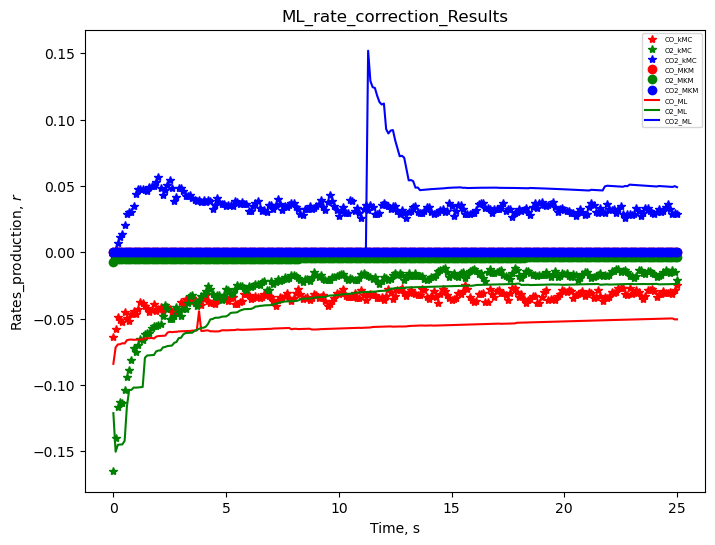

CPU times: user 1.15 s, sys: 209 ms, total: 1.36 s
Wall time: 272 ms


In [40]:
%%time
#%matplotlib notebook
plt.figure(figsize = (8, 6))
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='CO_kMC')        
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='O2_kMC') 
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='CO_MKM')        
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='O2_MKM') 
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='CO_ML')        
plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='O2_ML') 
plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

plt.xlabel('Time, s')
plt.ylabel("Rates_production, $r$")
plt.title('ML_rate_correction_Results')
plt.legend(fontsize=5, loc='best')
plt.show()

***
<a id="7"></a> 
## 7. Exploring and Evaluating possible ML options
<a href="#top">Back to top</a>
***

In [41]:
def BestModelRSCV(X_train, Y_train, algorithm="XGBoost", k_split = 2, disp_bp = False, Index='Sim_ndex',n_r_iter=10):
    from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
    #Note: The X_train and Y_train need to include index based on simulations to allow for correct tensor splitting
    ######### ALGORITHM OPTIONS: 'XGBoost','ANN','KNN','RandomForest', 'DecisionTree' #########
    #X_valid => Validation/Testing dataframe of whose indexes will be used get the simulation groups that will be used to perform cross validation
    #k_split = 2; Number of cross validation folds used in the random search cv for hyperameter tuning
    #disp_bp = False; If ture, it prints out the best parameters found for the best model used
    #Index = 'Sim_ndex' ; The specific index containing the groups of which will dictate how to split the validating/training folds

    #Preparing groupd based on Sim_ndex to perfrom cross validation
    groups = X_train.groupby(X_train['Sim_ndex']).groups
    # eg # {2012: [0, 1], 2013: [2], 2014: [3], 2015: [4, 5]}
    sorted_groups_listoflists = [value.to_list() for (key, value) in sorted(groups.items())]
    # eg # [[0, 1], [2], [3], [4, 5]]
    group = [item for sublist in sorted_groups_listoflists for item in sublist] #converting list of list to list
    
    #Removing the indexes not needed for training
    X_train_cv = X_train.drop(columns=['Sim_ndex','Sim_names'])
    Y_train_cv = Y_train.drop(columns=['Sim_ndex','Sim_names'])
    
    #Utilizing an external cross validation tool to perform KFold CV on the custom groups
    cv_outer = GroupKFold(n_splits=k_split) #Number of splits for cross validation
    
    #XGBoost
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost": 
        rs = RandomizedSearchCV(estimator = ML_model(X_train_cv, Y_train_cv, algorithm = 'XGBoost', mod_only=True),
                            param_distributions = {'booster': ['gbtree','gblinear','dart'],    
                               'n_estimators': [100,500,1000,5000],
                               'objective': ['reg:squarederror'],
                               'learning_rate': [0.001,0.01,0.1,1]},
                            cv=cv_outer, 
                            n_iter=n_r_iter)
        
        rs.fit(X_train_cv, Y_train_cv, groups=group) 
        if disp_bp == True:
            best_parms = rs.best_params_
            print('The randomly tuned best hyperparameters are:\n',best_parms)
            
        return rs
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
    
        #combo list represents: list of hidden layer option for CV search in the format : no_hid_layers,nodes_per_h_layer
        combo = [(1,64),(1,128),(2,64),(2,128),(3,64),(3,128),(4,64),(4,128)]
        hls_list = []
        for i in np.arange(len(combo)):
            hidden_layers = combo[i][1]*np.ones(combo[i][0]) 
            hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
            hls_list.append(hidden_layer_sizes)

        rs = RandomizedSearchCV(estimator = ML_model(X_train_cv, Y_train_cv, algorithm = 'ANN', mod_only=True),
                            param_distributions = {'hidden_layer_sizes': hls_list,
                               'activation': ['relu','tanh', 'logistic'],
                               'solver': ['lbfgs', 'sgd', 'adam']},
                            cv=cv_outer, 
                            n_iter=n_r_iter)

        rs.fit(X_train_cv, Y_train_cv, groups=group) 
        if disp_bp == True:
            best_parms = rs.best_params_
            print('The randomly tuned best hyperparameters are:\n',best_parms)

        return rs
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        rs = RandomizedSearchCV(estimator = ML_model(X_train_cv, Y_train_cv, algorithm = 'KNN', mod_only=True),
                            param_distributions = {"n_neighbors": range(1,51),
                                                   "weights": ['uniform', 'distance'],
                                                   "p": [1,2]},
                            cv=cv_outer, 
                            n_iter=n_r_iter)
        rs.fit(X_train_cv, Y_train_cv, groups=group) 
        if disp_bp == True:
            best_parms = rs.best_params_
            print('The randomly tuned best hyperparameters are:\n',best_parms)
            
        return rs
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        rs = RandomizedSearchCV(estimator = ML_model(X_train_cv, Y_train_cv, algorithm = 'RandomForest', mod_only=True),
                            param_distributions = {"n_estimators": [100,500,1000,5000]},  
                            cv=cv_outer, 
                            n_iter=n_r_iter)
        rs.fit(X_train_cv, Y_train_cv, groups=group) 
        if disp_bp == True:
            best_parms = rs.best_params_
            print('The randomly tuned best hyperparameters are:\n',best_parms)
            
        return rs
    
    #DecisionTree
    #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    elif algorithm=='DecisionTree':
        rs = RandomizedSearchCV(estimator = ML_model(X_train_cv, Y_train_cv, algorithm = 'DecisionTree', mod_only=True),
                            param_distributions = {"criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                                                   "max_depth": [10,20,50,100],
                                                   "min_samples_leaf": [10,20,50,100],
                                                  "min_samples_split": [10,20,50,100]},
                            cv=cv_outer, 
                            n_iter=n_r_iter)
        rs.fit(X_train_cv, Y_train_cv, groups=group) 
        if disp_bp == True:
            best_parms = rs.best_params_
            print('The randomly tuned best hyperparameters are:\n',best_parms)
            
        return rs

In [ ]:
%%time
#%matplotlib notebook
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

algs = ['XGBoost','ANN','KNN','RandomForest','DecisionTree']
rmse_vec = []
for v in np.arange(len(algs)):
    
    print("-"*50)
    print('Algorithm:',algs[v],'\n')
    
    start_time = time.time()  
    reg = BestModelRSCV(X_train_full, Y_train_full, algorithm=algs[v], k_split = 5, n_r_iter=20, disp_bp=True) 
    end_time = time.time()

    elapsed_time = end_time - start_time
    print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")
    
    Test_output = reg.predict(Test_input)

    Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2
    
    #Calculating extracted ML predicted rates
    ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
    for i in np.arange(np.shape(ML_Rates_pred)[0]):
        for j in np.arange(np.shape(ML_Rates_pred)[1]):
            ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])
    
    #Calculating the root mean squared of the test set
    rmse = sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred))
    print('\nRoot Mean Squared Error when using',algs[v],':\n',rmse)
    rmse_vec.append(rmse)
    
    plt.figure()
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='CO_kMC')        
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='O2_kMC') 
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='CO_MKM')        
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='O2_MKM') 
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

    plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='CO_ML')        
    plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='O2_ML') 
    plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

    plt.xlabel('Time, s')
    plt.ylabel("Rates_production, $r$")
    plt.title('Algorithm: {}'.format(algs[v]))
    plt.legend(fontsize=5, loc='best')

    plt.show()

--------------------------------------------------
Algorithm: XGBoost 



In [ ]:
print("The ML model giving the smallest rmse of", rmse_vec[np.argmin(rmse_vec)],"is : \n",algs[np.argmin(rmse_vec)]) 

<a href="#top">Back to top</a>

### Sample code for Performing cross validation:

In [ ]:
# from sklearn.model_selection import GroupKFold, cross_val_score

In [ ]:
# %%time
# #Performing cross validation

# #REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS so that they can be used for ML model training\


# groups = X_valid.groupby(X_valid['Sim_ndex']).groups
# # eg # {2012: [0, 1], 2013: [2], 2014: [3], 2015: [4, 5]}
# sorted_groups_listoflists = [value.to_list() for (key, value) in sorted(groups.items())]
# # eg # [[0, 1], [2], [3], [4, 5]]
# group = [item for sublist in sorted_groups_listoflists for item in sublist] #converting list of list to list

# X_valid_cv = X_valid.drop(columns=['Sim_ndex','Sim_names'])
# Y_valid_cv = Y_valid.drop(columns=['Sim_ndex','Sim_names'])

# from sklearn.ensemble import RandomForestRegressor
# cv_outer = GroupKFold(n_splits=2) #cv_func(2)
# cv_scores = cross_val_score(RandomForestRegressor(), 
#                             X_valid_cv, 
#                             Y_valid_cv, 
#                             cv=cv_outer, 
#                             groups = group)

# print('Average mean absolute error:', -cv_scores.mean())
# print('Accuracy standard deviation:', cv_scores.std()); 